We'll start by using the [markovify](https://github.com/jsvine/markovify/) library to make some individual sentences in the style of Jane Austen.  These will be the basis for generating a stream of synthetic documents.

In [1]:
import markovify
import codecs

with codecs.open("data/austen.txt", "r", "cp1252") as f:
    text = f.read()

austen_model = markovify.Text(text, retain_original=False, state_size=3)

for i in range(10):
    print(austen_model.make_short_sentence(200))

I cannot doubt it.
In anticipating the happiness of one of those that spare their own trouble; and Nanny shall fetch her, however it may make against his interest or pleasure.
This, and the manner in which Miss Thorpe's name was included, passed his lips.
She was forced to yield, and instead of Captain Benwick, she had Captain Harville by her side.
Anne could not pay, they had only accomplished some views of St. Mark's Place, Venice, when Frank Churchill entered the room.
How it could occur a second time, by any word, or look, or movement.
Happily for her companion, she wanted no answer.
Her brother told her that he could not yet recover from the emotion of hearing herself so spoken of.
They were all very seriously frightened.
She repeated it to you.


Constructing single sentences is interesting, but we'd really rather construct larger documents. Here we'll construct a series of documents that have, on average, five sentences.

In [2]:
from scipy.stats import poisson

for sentences in poisson.rvs(5, size=10):
    print(" ".join([austen_model.make_short_sentence(200) for _ in range(sentences + 1)]))
    print("\n###\n")

He seems to have been. Her manners were by no means forgotten the past, and carrying her out of all proportion. Each faulty propensity in leading him to evil, had led him likewise to punishment. Soup too! The remembrance of her first attempts, as the best fitted for a beginner that either stable could furnish.

###

In a few moments every one was silent. Poor soul! To spare Henrietta from agitation seemed the governing principle. On the contrary, there is something much more pleasing in his countenance. He is blinded, and nothing will open his eyes; nothing can, after having had truths before him so long in company with her than ever by absence, unhappiness, and danger. Did she love him well enough to follow his friends, as he had the means of uniting them. To the Great House family, which was generally, as Anne very well knew, the least to blame. He looked as if he had not heard his carriage announced, and was first called to the card-table by the conclusion of your letter declares yo

We'll use spaCy to identify entities (mostly proper nouns and noun phrases) in these synthetic status updates and turn them into hashtags:

In [3]:
import spacy
nlp = spacy.load('en')

def make_sentence(model, length=200):
    return model.make_short_sentence(length)
    
def hashtagify_full(sentence):
    doc = nlp(sentence)
    for ent in doc.ents:
        sentence = sentence.replace(str(ent), "#%s" % str(ent).replace(" ", ""))
    return (sentence, ["#%s" % str(ent).replace(" ", "") for ent in doc.ents])

def hashtagify(sentence):
    result,_ = hashtagify_full(sentence)
    return result

for i in range(5):
    sentence = make_sentence(austen_model)
    print(sentence)
    print(hashtagify(sentence))

In half a minute of starting the idea that we have all such reason to love, and such love must unite them.
In #halfaminute of starting the idea that we have all such reason to love, and such love must unite them.
_Courtship_--a very good hint.
_Courtship_--a very good hint.
Nature resisted it for a play, and with you.
Nature resisted it for a play, and with you.
She need not have been decided quite so soon.
She need not have been decided quite so soon.
The former was for Sir John's gratification, the latter for that of his regret at having believed the contrary himself.
The former was for Sir #John's gratification, the latter for that of his regret at having believed the contrary himself.


We'll now train two Markov models on positive and negative product reviews (taken from the [public-domain Amazon fine foods reviews dataset on Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews/)).  We'll incorporate the results of these models into our synthetic social media stream.

In [4]:
import gzip

def train_markov_gz(fn):
    """ trains a Markov model on gzipped text data """
    with gzip.open(fn, "rt", encoding="utf-8") as f:
        text = f.read()
    return markovify.Text(text, retain_original=False, state_size=3)

negative_model = train_markov_gz("data/reviews-1.txt.gz")
positive_model = train_markov_gz("data/reviews-5-100k.txt.gz")

In [5]:
make_sentence(negative_model)

'From the 16 year old cat in to the trash.'

In [6]:
make_sentence(positive_model)

'I wish more similar products existed.'

We can combine these models with relative weights, but this yields somewhat unusual results:

In [7]:
compound_model = markovify.combine([austen_model, negative_model, positive_model], [14, 3, 3])

In [8]:
for i in range(20):
    print(hashtagify(make_sentence(compound_model)))

So, with the creamy, smooth texture and good flavor.
Just not worth $#25.00 a pound no matter where they are, if they think people won't notice?
Just be careful the ##first couple times I made tea with it, it popped the same as my ##first order #1.2 oz- #6 pack.
Within a very short amount of time.
Your mother insists upon your accepting it.
It is sweet, but not as rich as we would like them being in #3 separate packages allows me to eat at #night.
So if your wanting #theJamaicaGinger dont waist your time The expiration date is #September so it should be renamed.
When or little girl #Kimberly12yearsold and they went bad before he finished them.
A friend brought me down a box of other randoms she no longer experiences constipation.
These are reasonably priced and arrived in good shape.
Shame on me for not showing it to him though... he tried to be all out of my small backyard operation.
And unlike many snacks, after you eat them.
I should check the meaning of this?
After these came a #se

As is more or less the case in the real world, we'll assume that a small percentage of users are responsible for the bulk of social media activity, and that the bulk of users are responsible for relatively few posts.  We'll model this with a table of random user IDs that has a collection of relatively few talkative users and relatively many moderate users; the proportion of utterances from talkative users to utterances from moderate users is the inverse of the proportion of talkative users to moderate users.

In [9]:
import numpy
import math
import collections

class UserTable(object):
    def __init__(self, size, weights=[8, 2]):
        self._talkative = collections.deque()
        self._moderate = collections.deque()
        self._size = size
        self._cutoff = float(weights[0]) / sum(weights)
        
        for i in range(size):
            new_uid = math.floor(numpy.random.uniform(10 ** 10))
            if numpy.random.uniform() >= self._cutoff:
                self._moderate.append(new_uid)
            else:
                self._talkative.append(new_uid)
    
    def random_uid(self):
        def choose_from(c):
            return c[math.floor(numpy.random.uniform() * len(c))]
        
        if numpy.random.uniform() >= self._cutoff:
            return choose_from(self._talkative)
        else:
            return choose_from(self._moderate)
        

In [10]:
import seaborn

We can see the number of times each user ID appears if we ask the `UserTable` for 1000 random user IDs:

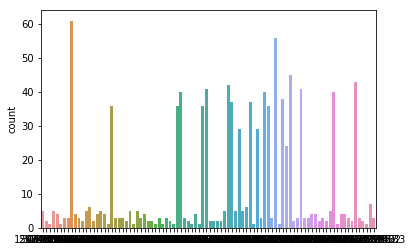

In [11]:
ut = UserTable(100)
uids = [ut.random_uid() for i in range(1000)]
seaborn.countplot(uids)

In [12]:
def generate_tweets(models, weights=None, hashtag_weights=[8, 2], ut=None, seed_hashtags=[]):
    if weights is None:
        weights = [1] * len(models)
    
    if ut is None:
        ut = UserTable(10000)
    
    choices = []
    
    total_weight = float(sum(weights))
    
    for i in range(len(weights)):
        choices.append((float(sum(weights[0:i+1])) / total_weight, models[i]))
    
    def choose_model():
        r = numpy.random.uniform()
        for (p, m) in choices:
            if r <= p:
                return m
        return choices[-1][1]
    
    seen_hashtags = set()
    hashtags = []
    total_hashtag_weight = float(sum(hashtag_weights))
    for i in range(len(hashtag_weights)): 
        hashtags.append((float(sum(hashtag_weights[0:i+1])) / total_hashtag_weight, collections.deque()))
    
    iws = [1.0 - w for (w, _) in hashtags]
    inverse_weights = [(sum(iws[0:i+1]), i) for _, i in zip(iws, range(len(iws)))]    

    def choose_from(c):
        idx = math.floor(numpy.random.uniform() * len(c))
        return c[idx]
    
    def store_hashtag(tag):
        if tag not in seen_hashtags:
            seen_hashtags.add(str(tag))
            r = numpy.random.uniform()
            for(p, deq) in hashtags:
                if r <= p:
                    deq.append(tag)
    
    def choose_hashtag():
        r = numpy.random.uniform()
        for(p, i) in hashtags:
            if r <= - p and len(hashtags[i][1]) > 0:
                return choose_from(hashtags[i][1])
        return len(hashtags[0][1]) > 0 and choose_from(hashtags[0][1]) or choose_from(hashtags[1][1])
    
    for tag in seed_hashtags:
        seen_hashtags.add(str(tag))
        hashtags[-1][1].append(str(tag))
    
    while True:
        tweet, tags = hashtagify_full(make_sentence(choose_model()))
        for tag in tags:
            store_hashtag(str(tag))
        
        this_tweet_tags = set([str(t) for t in tags])
        
        if len(seen_hashtags) > 0:
            for i in range(min(numpy.random.poisson(3), len(seen_hashtags))):
                tag = choose_hashtag()
                if str(tag) not in this_tweet_tags:
                    this_tweet_tags.add(str(tag))
                    tweet += " %s" % str(tag)
            
        yield (ut.random_uid(), tweet)

In [13]:
seed_hashtags=["#ff", "#marketing", "#fail", "#followfriday", "#yolo", "#retweet", "#tbt", "#socialmedia", "#startup", "#blogpost", "#news", "#health"]

t = generate_tweets([austen_model, positive_model, negative_model, compound_model], [22, 4, 4, 2], seed_hashtags=seed_hashtags)

In [14]:
t

<generator object generate_tweets at 0x1aa941d678>

In [15]:
[next(t) for i in range(100)]

[(4147830156, 'Sir #Thomas was at hand.'),
 (8638342915,
  'She was vexed beyond what could have been expressed--almost beyond what she knew to be thoroughly deserved by Mrs. #Weston; but, undoubtedly he could know very little of #LadyCatherine or her daughter. #Thomas'),
 (1493139267,
  "It didn't taste like wax, they might taste like this. #Thomas #LadyCatherine"),
 (9425213566,
  'They arrived in due time at the place of destination, and as soon as possible after themselves, for the purpose than that which yet bore the traces of monastic division? #LadyCatherine'),
 (1036796332,
  'This product is expensive for this use - honey is cheaper and ##Amazon offers the best deal on ##Amazon. #Thomas #LadyCatherine'),
 (3407465369,
  '#Elizabeth, at work in the garden or in reading and writing, and looking out of the room. #Thomas'),
 (1723739557, 'I am tired of doing nothing. #Thomas #Elizabeth'),
 (5079931871, 'The place was suited to meditation. #Elizabeth #LadyCatherine'),
 (631488302,


In [ ]:
import cProfile

def timing(c):
    for _ in range(c):
        next(t)

cProfile.run('timing(2000)', 'generatestats')

In [ ]:
import pstats
p = pstats.Stats('generatestats')
p.strip_dirs().sort_stats(-1).print_stats()